# Preparations

In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (8,6)

In [2]:
# Some parameters of the simulations to be analyzed
rounds = 50
vehicle_limit = 80

rate_range = np.append(np.arange(2,66,2), [1000])
target_number_of_rounds = 15

all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]
sub_routes = [[0, 1], [2, 3]]

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [3]:
def preprocess_record(record, routes):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

    # Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
    # in a list that shows all the possible routes
    record["Road_order_label"] = record.apply(lambda row: routes.index(row.Road_order), axis=1)
    return record

## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [4]:
def preprocess_utility(utility):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
    utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
    return utility

## Functions needed

In [5]:
def avg_total_time(df, target_number_of_rounds, rounds):
    """
    Computes the average total time spent by all vehicles per round for 
    the last n rounds. (n is specified in the function input)
    
    Parameters:
        df (pd.DataFrame): dataframe that records vehicle-specific data of all
                           rounds in a simulation run
        target_number_of_rounds (integer): how many rounds to be considered in
                                           the average time calculation
        rounds (integer): total number of rounds
    """
    
    pivot_df = pd.pivot_table(df, values='Total_time', 
                              index='Round_number', 
                              aggfunc=np.sum).reset_index(drop=False)
    return pivot_df.loc[pivot_df.Round_number>(rounds-target_number_of_rounds)].Total_time.mean()

In [6]:
def route_avg_time(ax, 
                   fig,
                   y_range,
                   record_df, 
                   number_of_routes,
                   rate):
    """
    Plot the average time to arrive grouped by each route and round.
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        record_df: dataframe that contains data recorded in the simulation
        number_of_routes: number of routes involved (number of lines to be plotted)
        rate: the corresponding vehicle rate
        
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive (s)")
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_title(f"Vehicle rate={rate}")
 
    return ax

In [7]:
def route_taken_number(ax,
                       fig,
                       y_range,
                       utility_df, 
                       rounds, 
                       number_of_routes, 
                       rate):
    """
    Plot the changes in number of vehicles that took the route over time.
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        utility_df: stores utility-related data
        rounds: number of rounds in utility_df
        number_of_routes: number of routes involved (number of lines to be plotted)
        rate: the corresponding vehicle rate
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], color=colors[i])
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles")
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_title(f"Vehicle rate={rate}")
    
    return ax

In [8]:
def route_chosen_probability(ax,
                             fig,
                             y_range,
                             rounds, 
                             number_of_routes, 
                             rate,
                             folder_name):
    """
    Plot the changes in probabilities of choosing each route over time.    
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        rounds: number of rounds in utility_df
        number_of_routes: number of routes involved (number of lines to be plotted)
        rate: the corresponding vehicle rate
        folder_name: the folder that stores all the utility data files
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability")
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_title(f"Vehicle rate={rate}")
    
    return ax

In [9]:
def total_utility(target_number_of_rounds, 
                  rounds, 
                  rate,
                  folder_name,
                  save_dir=None):
    
    """
    Return the total utility values of all vehicles in each of the last few rounds.
    The number of rounds is specified by 'target_number_of_rounds'.
    
    Parameters:
        target_number_of_rounds: how many rounds to be considered in
                                 the average utility calculation
        rounds: total number of rounds
        rate: the corresponding vehicle rate
        folder_name: the folder that stores all the utility data files
    """
    
    total_utilities = np.zeros((target_number_of_rounds))
    
    for r in range(rounds-target_number_of_rounds+1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Utilities'] = df.apply(lambda row: ast.literal_eval(row['Utilities']), axis=1)
        df['Routes_taken'] = df.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
        
        for idx, row in df.iterrows():
            route_taken = row['Routes_taken'][-1]
            utility = row['Utilities'][route_taken]
            
            total_utilities[r-(rounds-target_number_of_rounds+1)] += utility
    return total_utilities

# Visualization

In [10]:
# Define the layout of how the subplots are placed
row, col = 5, 4
width, height = 14, 15

## - The average time needed to reach destination by different routes
Note: here only a subset of all the vehicle rates are plotted, which are used in the main text of the thesis.

### Zero alpha case

In [11]:
tmp_rate_range = [2, 6, 10, 12, 
                  14, 16, 18, 20, 
                  22, 26, 30, 34, 
                  38, 40, 44, 48, 
                  52, 56, 62, 1000]
y_ranges = [[30, 110], [30, 140],
            [35, 210], [65, 225],
            [80, 280]]

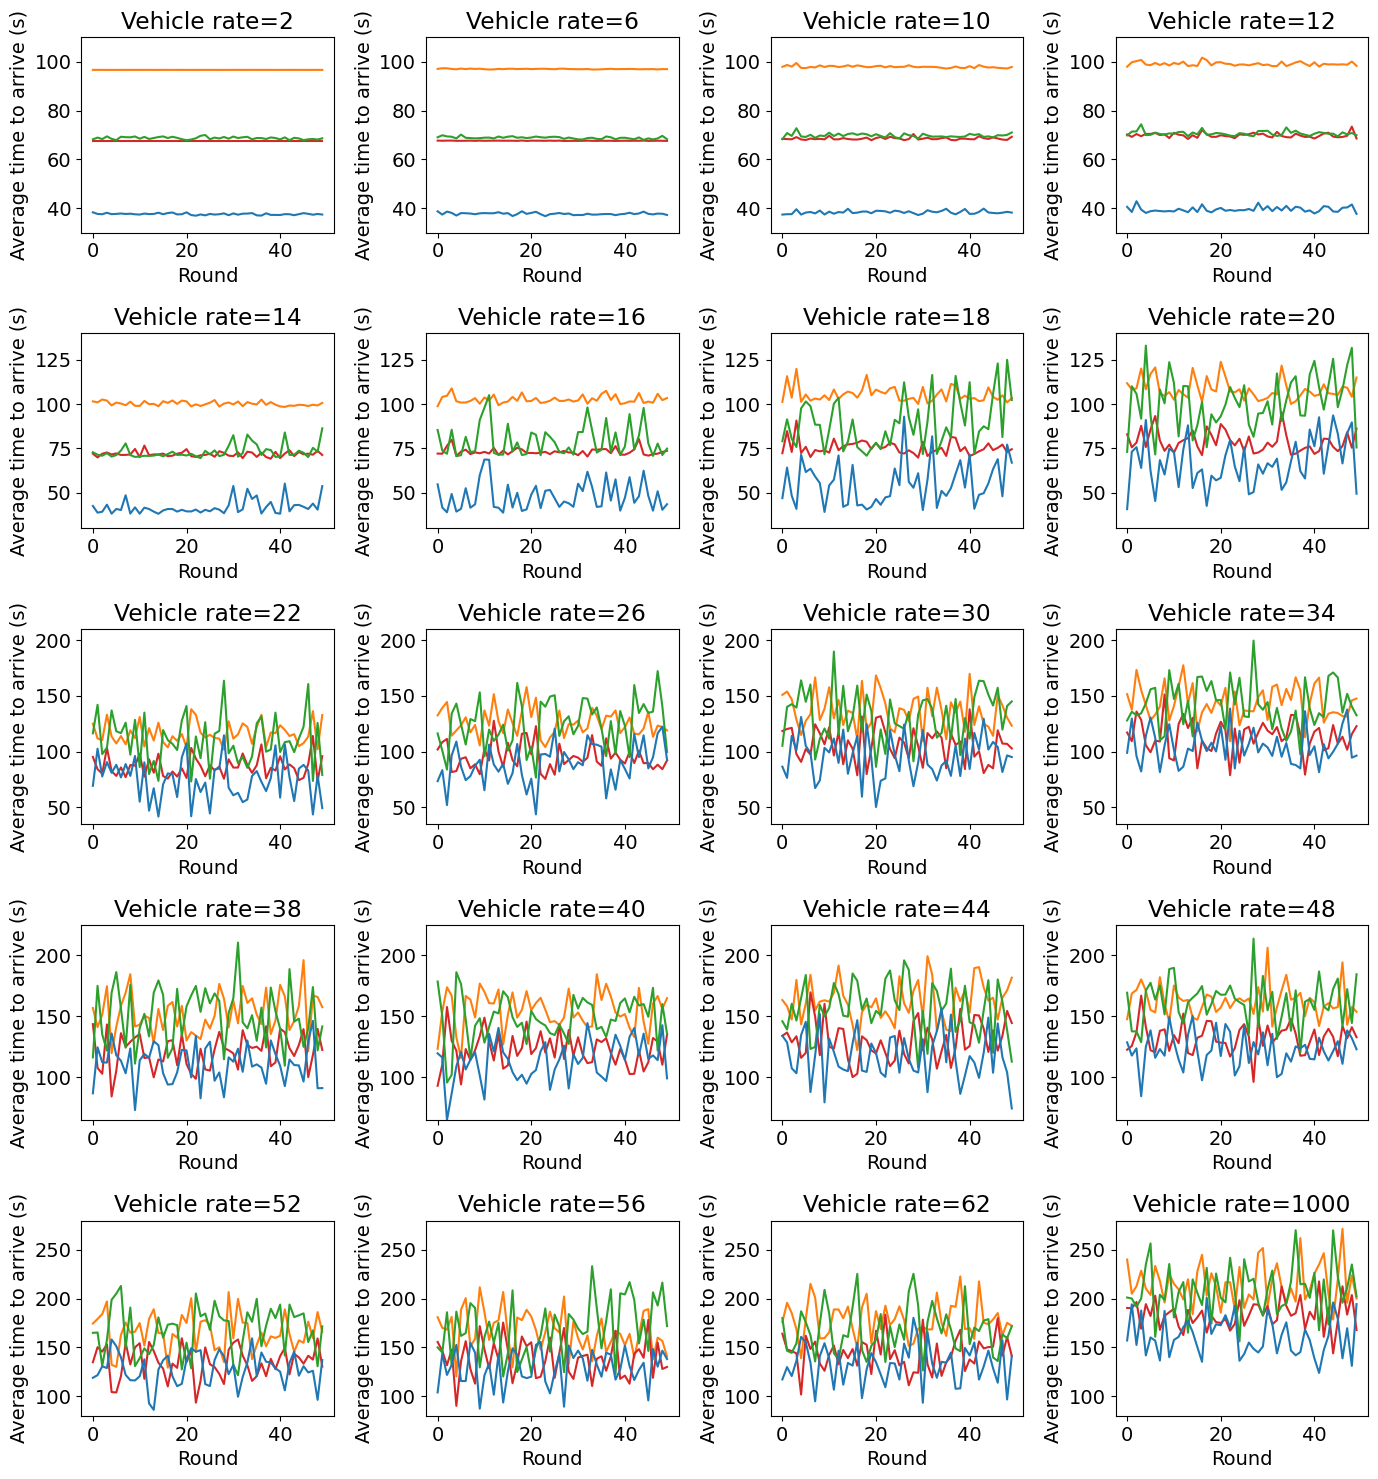

In [12]:
fig, axs = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)

    ax = route_avg_time(axs[idx//col, idx%col], 
                        fig,
                        y_ranges[idx//col],
                        record_df=record_df, 
                        number_of_routes=len(all_routes),
                        rate=i,
                       )
    axs[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs[row-1, col-g].axis('off')
    
plt.tight_layout()
plt.savefig("Analysis/Avg_time_by_route_zero_alpha_reduce.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

### No connection case

In [13]:
tmp_rate_range = [2, 6, 8, 14, 
                 16, 18, 20, 22,
                 24, 26, 28, 34,
                 38, 40, 44, 48,
                 52, 56, 62, 1000]
y_ranges = [[67, 71], [68, 105],
            [68, 140], [70, 160],
            [85, 200]]

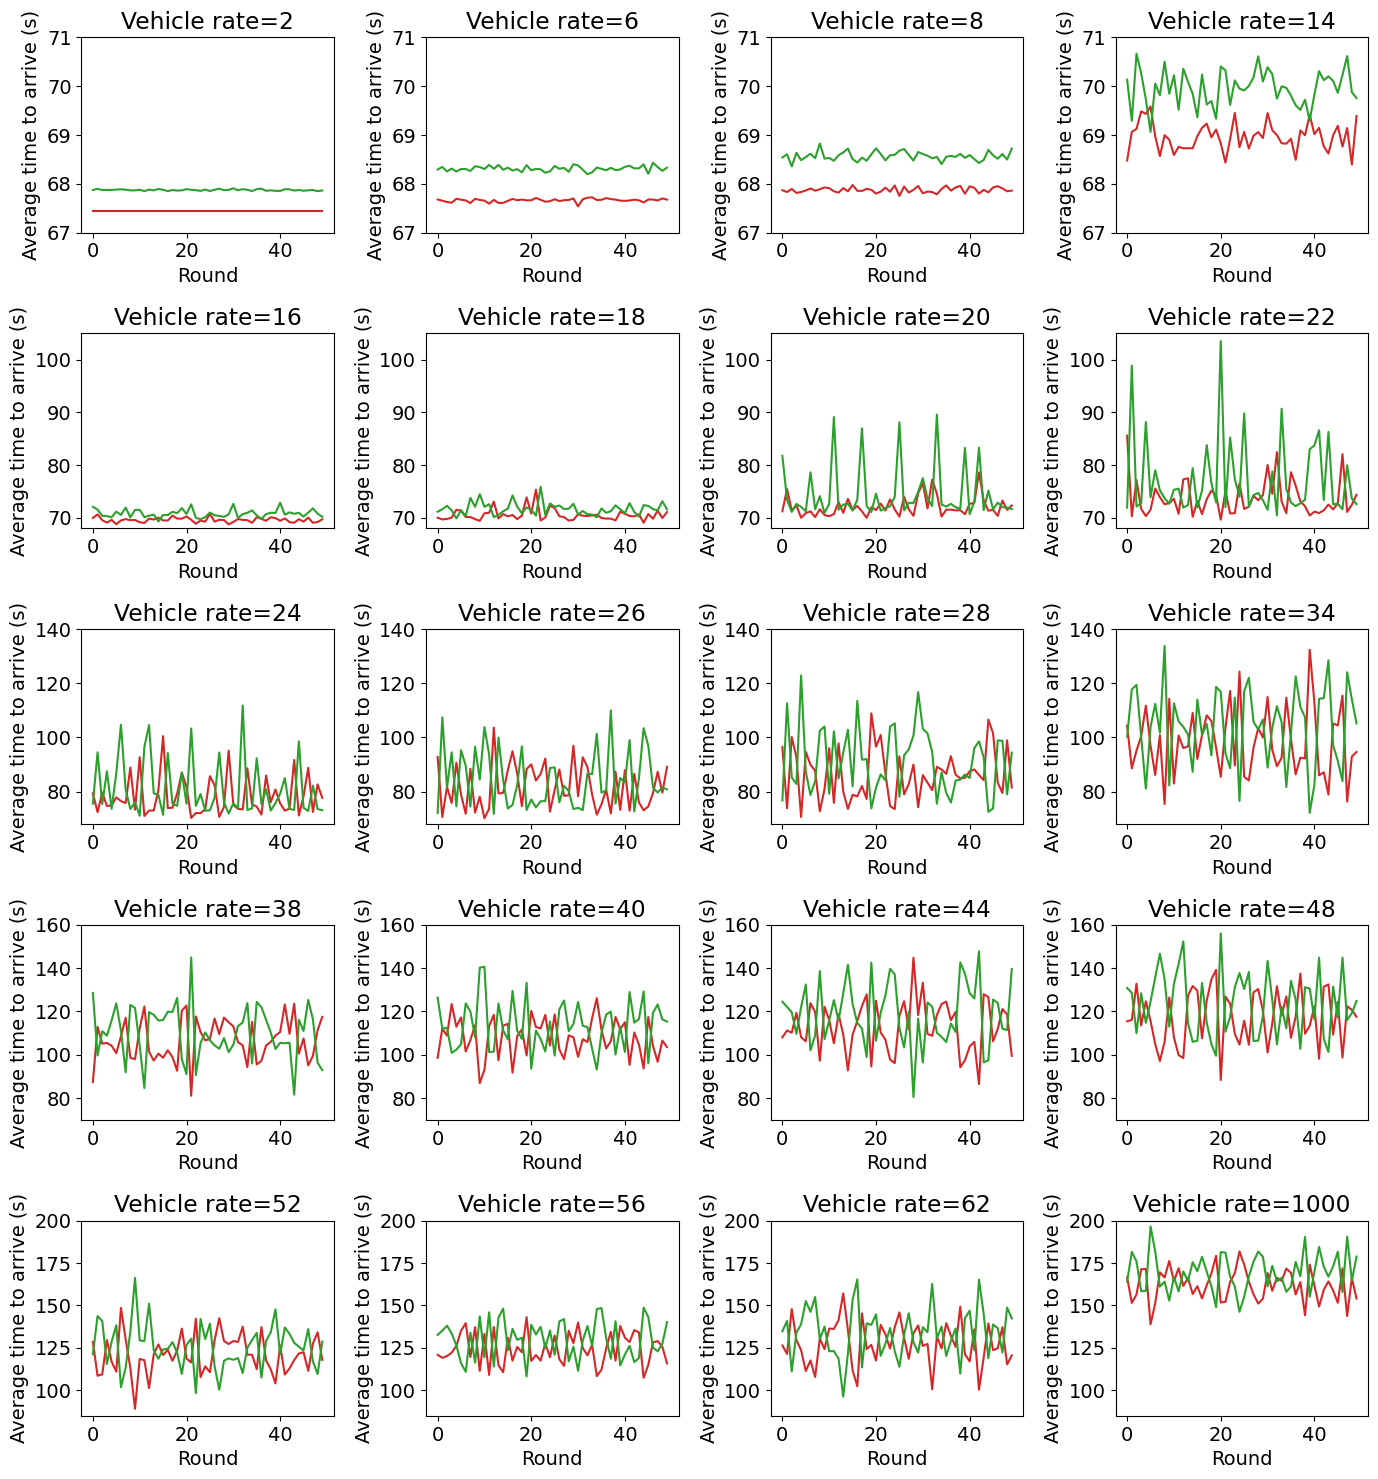

In [14]:
fig2, axs2 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, sub_routes)

    ax = route_avg_time(axs2[idx//col, idx%col], 
                       fig2,
                       y_ranges[idx//col],
                       record_df=record_df, 
                       number_of_routes=len(sub_routes),
                       rate=i,
                      )
    
    axs2[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs2[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Avg_time_by_route_no_connection_reduce.png", 
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The number of vehicles that choose a route over time
Note: here only a subset of all the vehicle rates are plotted, which are used in the main text of the thesis.

### Zero alpha case

In [15]:
tmp_rate_range = [2, 6, 10, 14, 
                 16, 18, 20, 22,
                 24, 26, 28, 34,
                 38, 40, 44, 48,
                 52, 56, 62, 1000]
y_ranges = [[3, 48], [5, 40],
            [5, 40], [7, 35],
            [7, 40]]

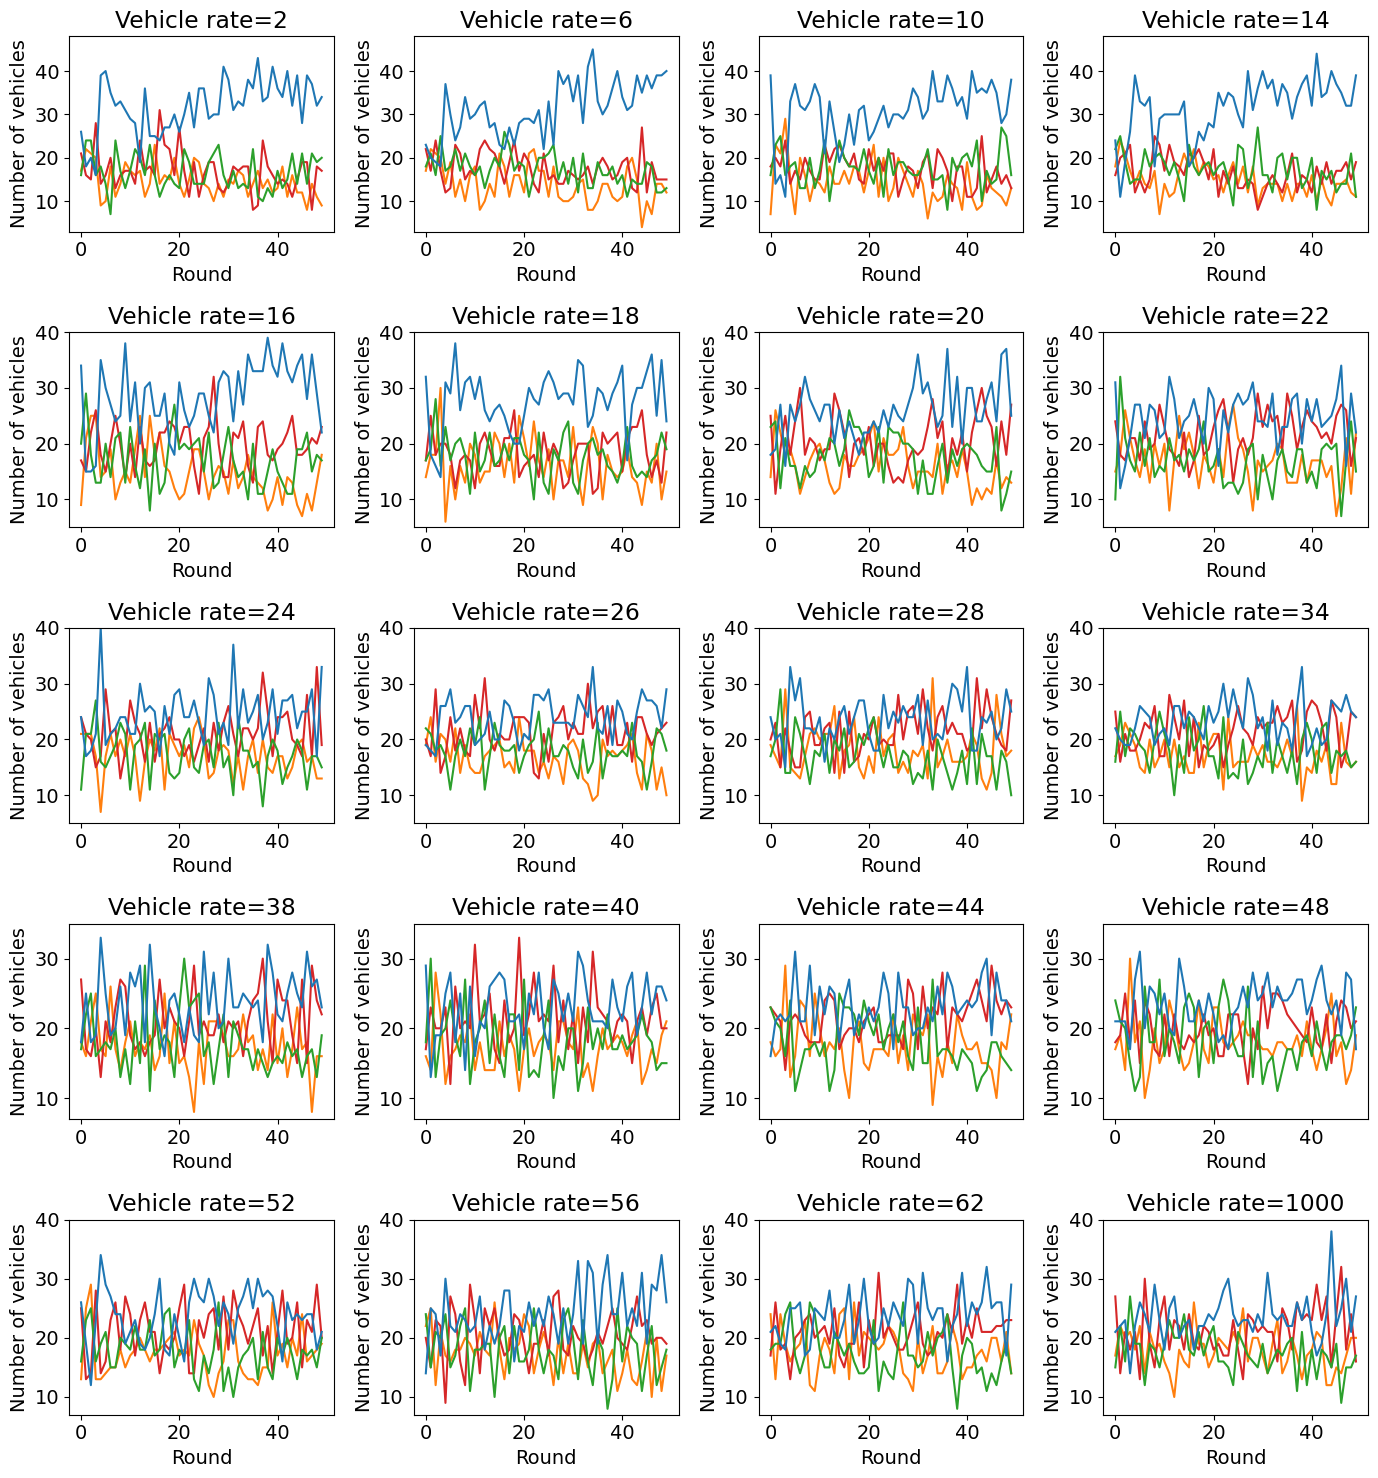

In [16]:
fig3, axs3 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    utility_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    ax = route_taken_number(axs3[idx//col, idx%col], 
                            fig3,
                            y_ranges[idx//col],
                            utility_df,
                            rounds, 
                            len(all_routes),
                            i
                           )
    axs3[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs3[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Vehicle_number_by_route_zero_alpha_reduce.png",
            bbox_inches='tight', pad_inches=0.25)
plt.show()

### No connection case

In [17]:
tmp_rate_range = [2, 6, 10, 14, 
                 16, 18, 20, 22,
                 24, 26, 28, 34,
                 38, 40, 44, 48,
                 52, 56, 62, 1000]
y_ranges = [[23, 57], [23, 57],
            [23, 57], [25, 57],
            [23, 57]]

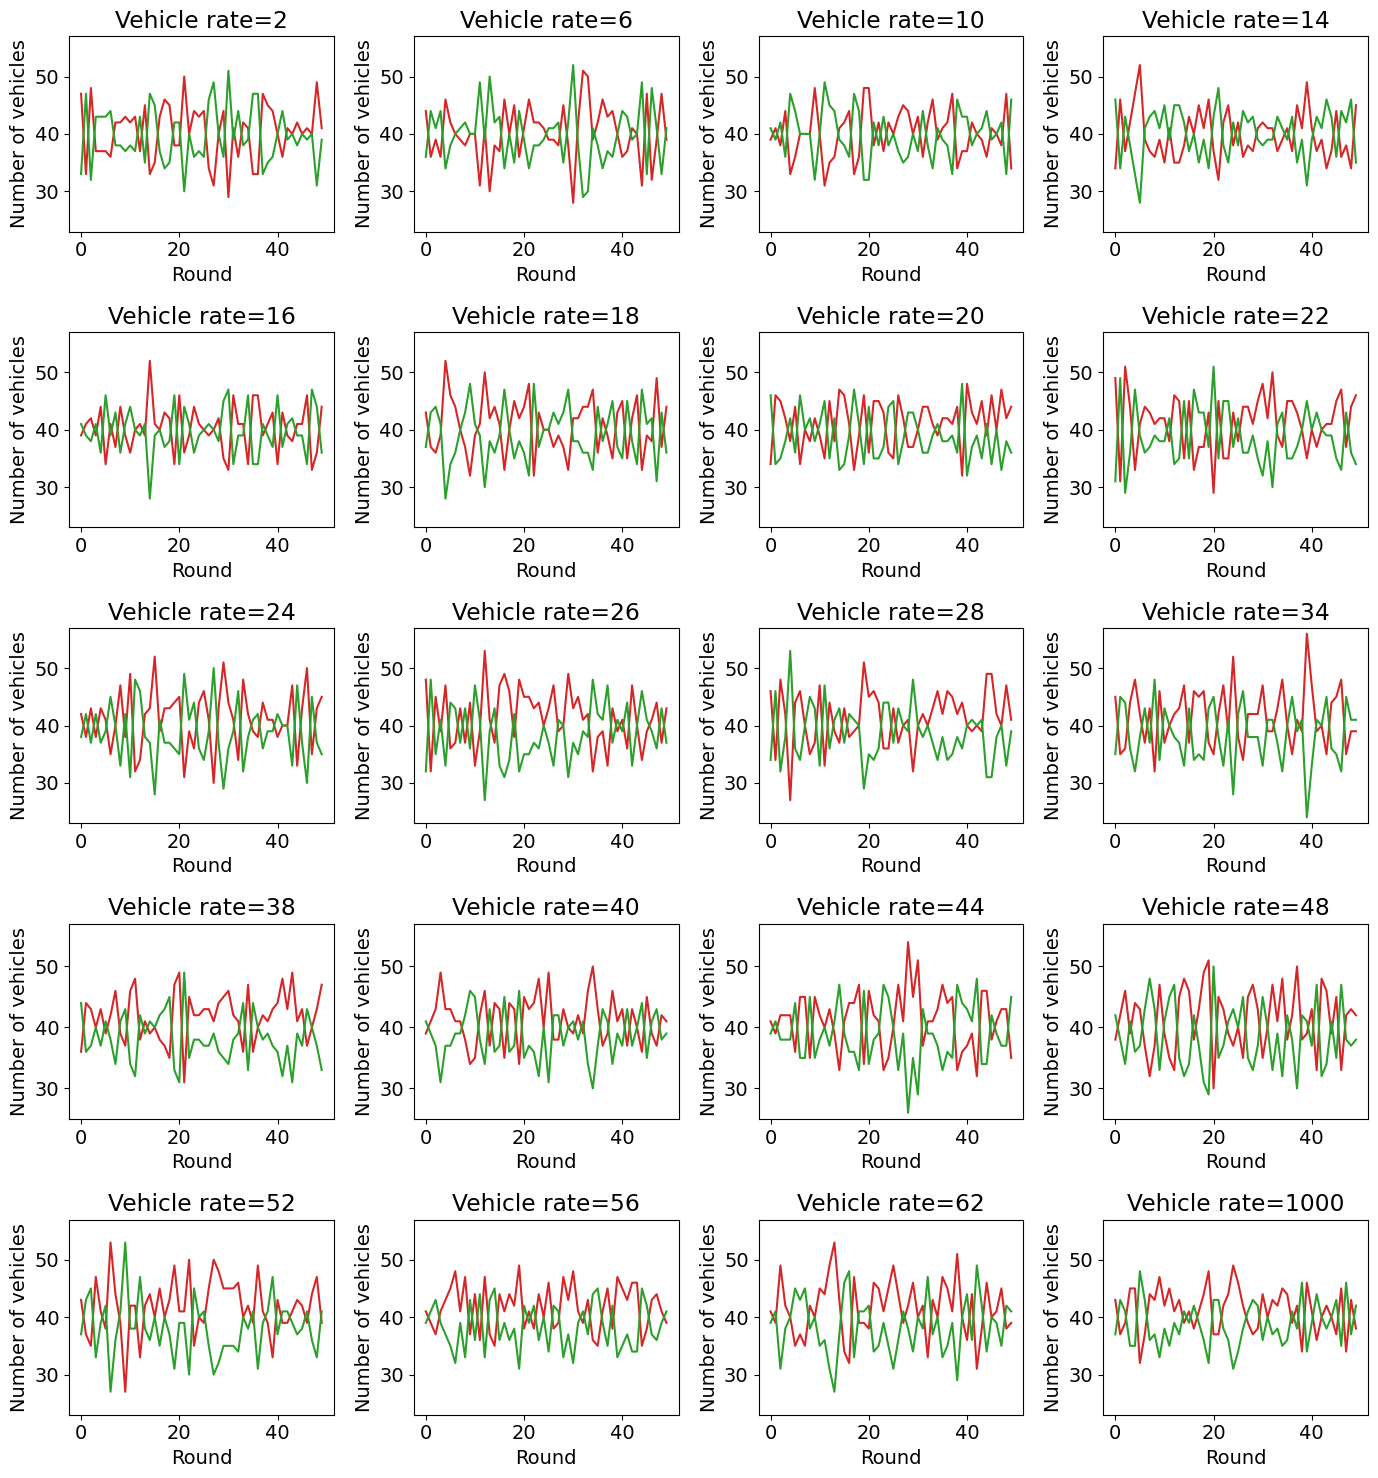

In [18]:
fig4, axs4 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    utility_df = pd.read_csv(f'1.2 No connection/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    ax = route_taken_number(axs4[idx//col, idx%col], 
                            fig4,
                            y_ranges[idx//col],
                            utility_df,
                            rounds, 
                            len(sub_routes),
                            i
                           )
    axs4[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs4[row-1, col-g].axis('off')
    
plt.tight_layout()
plt.savefig("Analysis/Vehicle_number_by_route_no_connection_reduce.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The probabilities of choosing different routes over time
Note: here only a subset of all the vehicle rates are plotted, which are used in the main text of the thesis.

### Zero alpha case

In [19]:
tmp_rate_range = [2, 6, 10, 14, 
                 16, 18, 20, 22,
                 24, 26, 28, 34,
                 38, 40, 44, 48,
                 52, 56, 62, 1000]
y_ranges = [[0.1, 0.48], [0.15, 0.45],
            [0.15, 0.42], [0.15, 0.4],
            [0.15, 0.38]]

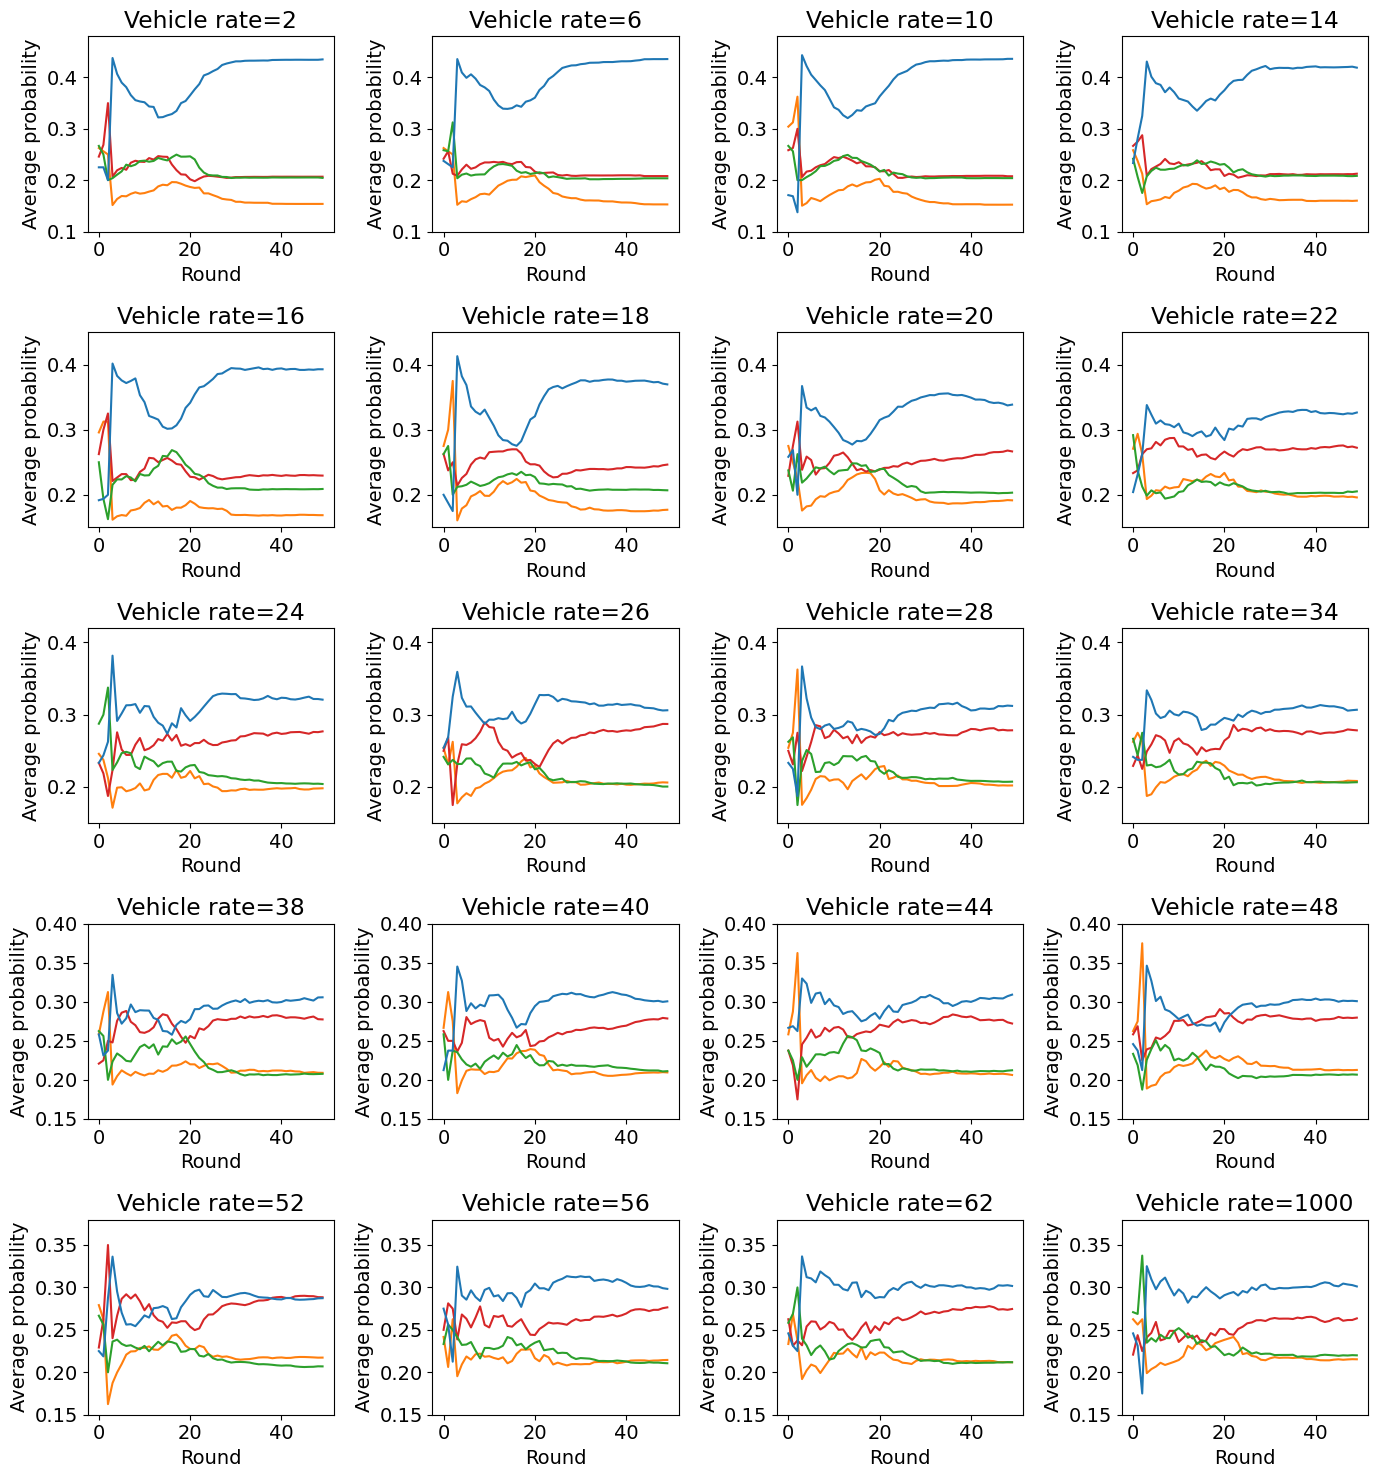

In [20]:
fig5, axs5 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    
    ax = route_chosen_probability(axs5[idx//col, idx%col], 
                                  fig5,
                                  y_ranges[idx//col],
                                  rounds,
                                  len(all_routes),
                                  i,
                                  "1.1 Zero alpha"
                                 )
    axs5[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs5[row-1, col-g].axis('off')

plt.tight_layout()
plt.savefig("Analysis/Average_probability_by_route_zero_alpha_reduce.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

### No connection case

In [21]:
tmp_rate_range = [2, 6, 10, 14, 
                 16, 18, 20, 22,
                 24, 26, 28, 34,
                 38, 40, 44, 48,
                 52, 56, 62, 1000]
y_ranges = [[0.4, 0.6], [0.38, 0.62],
            [0.38, 0.62], [0.42, 0.57],
            [0.42, 0.57]]

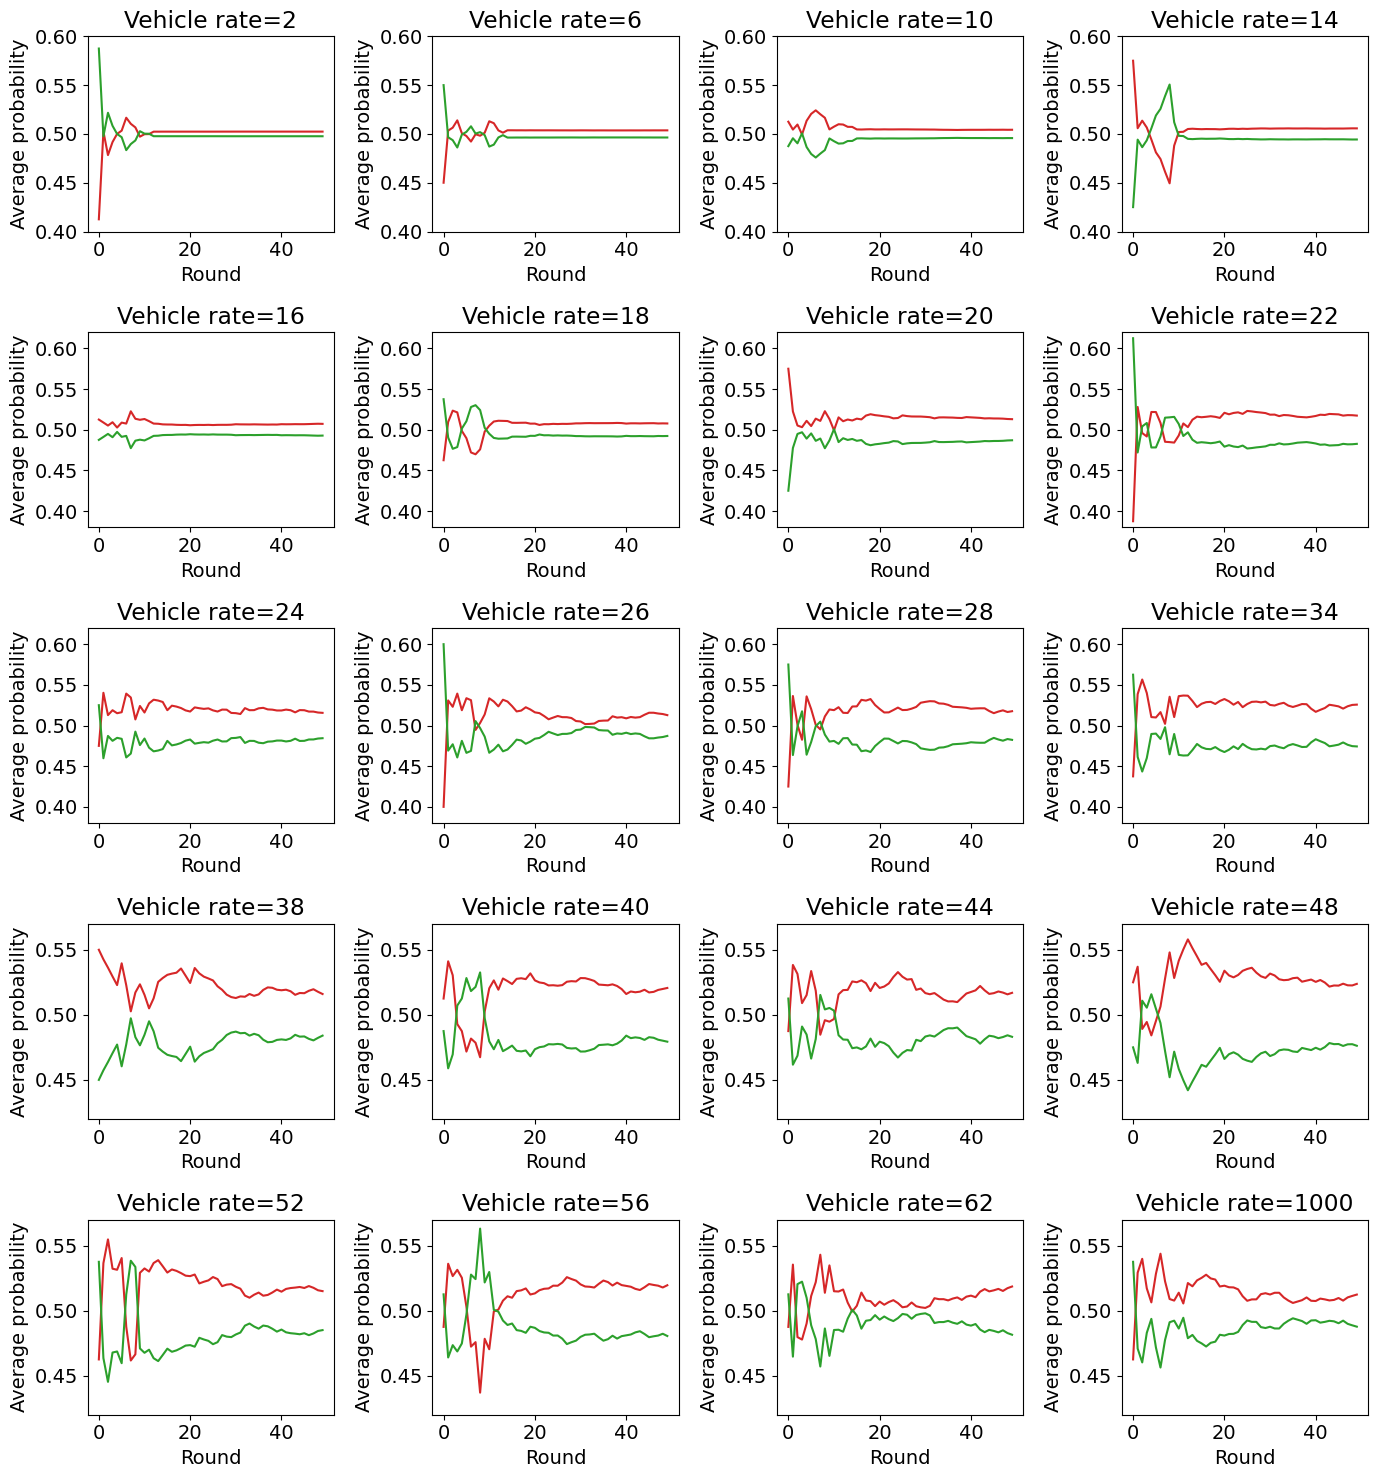

In [22]:
fig6, axs6 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(tmp_rate_range)):
    i = tmp_rate_range[idx]
    
    ax = route_chosen_probability(axs6[idx//col, idx%col], 
                                  fig6,
                                  y_ranges[idx//col],
                                  rounds,
                                  len(sub_routes),
                                  i,
                                  "1.2 No connection"
                                 )
    axs6[idx//col, idx%col] = ax

for g in range(1, row*col-idx):    
    axs6[row-1, col-g].axis('off')    

plt.tight_layout()
plt.savefig("Analysis/Average_probability_by_route_no_connection_reduce.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The average travel time per vehicle and traffic flux in the last few rounds

In [23]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is a middle connection in the topology
avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    avg_times.append(avg_time/vehicle_limit)

In [24]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is no middle connection in the topology
opt_avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    opt_avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    opt_avg_times.append(opt_avg_time/vehicle_limit)

### Average travel time

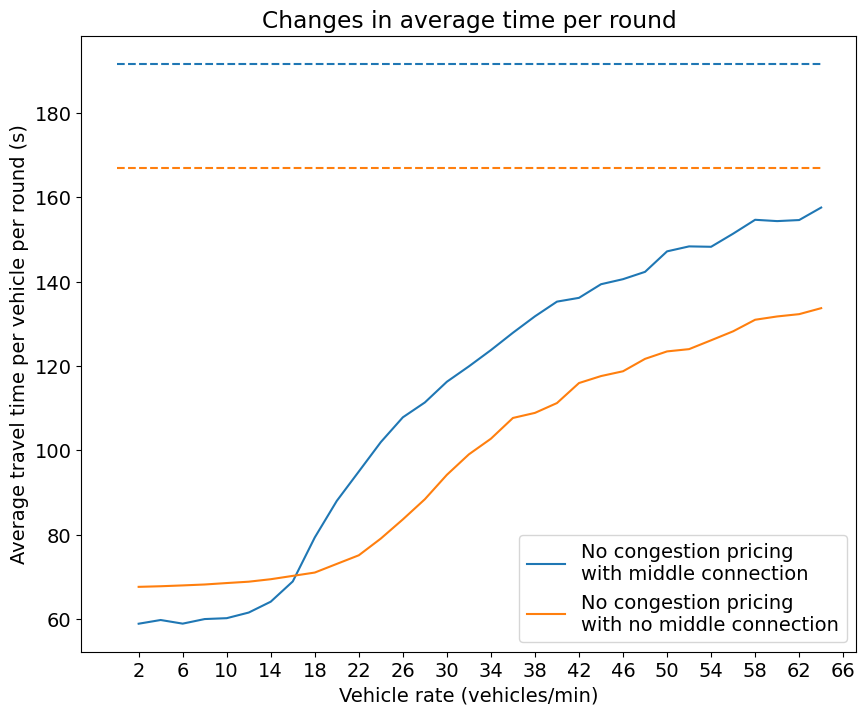

In [25]:
plt.rcParams["figure.figsize"] = (10,8)

# Plot the data points except for when the vehicle rate is 1000
plt.plot(rate_range[:-1], avg_times[:-1], label='No congestion pricing\nwith middle connection')
plt.plot(rate_range[:-1], opt_avg_times[:-1], label='No congestion pricing\nwith no middle connection')

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.xticks(np.arange(min(rate_range[:-1]), max(rate_range[:-1])+4, 4))
plt.hlines(opt_avg_times[-1], 0, 64, linestyles='--', color='tab:orange')
plt.hlines(avg_times[-1], 0, 64, linestyles='--', color='tab:blue')

# Add other plot features
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel("Average travel time per vehicle per round (s)")
plt.title("Changes in average time per round")
plt.legend(loc='lower right')

plt.savefig("Analysis/Change_in_avg_travel_time_per_round_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

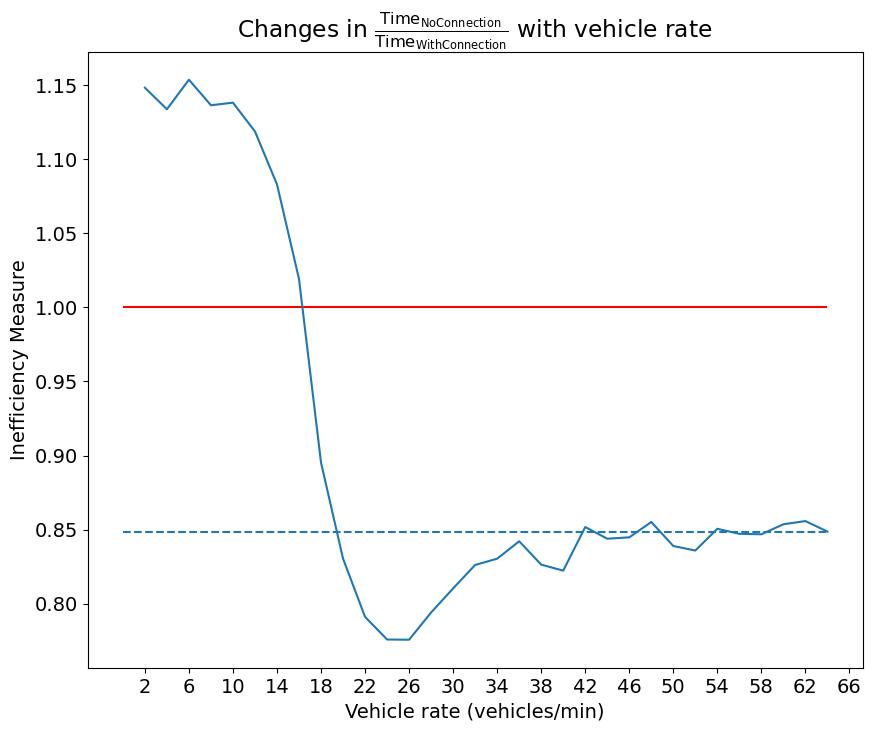

In [26]:
# Plot the data points except for when the vehicle rate is 1000
PoA = [opt_avg_times[i] / avg_times[i] for i in range(len(opt_avg_times)-1)]
plt.plot(rate_range[:-1], PoA)

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.hlines(PoA[-1], 0, 64, linestyles='--', color='tab:blue')

# Add other plot features
plt.hlines(1, 0, 64, color='r')
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel(r"Inefficiency Measure")
plt.title(r"Changes in $\frac{\mathrm{Time}_{\mathrm{NoConnection}}}{\mathrm{Time}_{\mathrm{WithConnection}}}$ with vehicle rate")
plt.xticks(np.arange(min(rate_range[:-1]), max(rate_range[:-1])+4, 4))

plt.savefig("Analysis/Changes_in_Inefficiency_with_rate_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

### Traffic flux

In [27]:
target_number_of_rounds = 15
round_times = []

# Computes the average duration of one round
for i in rate_range:
    df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    
    round_time = df.loc[(df.Vehicle_label==(vehicle_limit-1)) & \
                        (df.Round_number>(rounds-target_number_of_rounds))].Total_time.mean()
    round_time += (vehicle_limit-1) * 60/i
    round_times.append(round_time)

In [28]:
opt_round_times = []

# Computes the average duration of one round
for i in rate_range:
    df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    
    round_time = df.loc[(df.Vehicle_label==(vehicle_limit-1)) & \
                        (df.Round_number>(rounds-target_number_of_rounds))].Total_time.mean()
    round_time += (vehicle_limit-1) * 60/i
    opt_round_times.append(round_time)

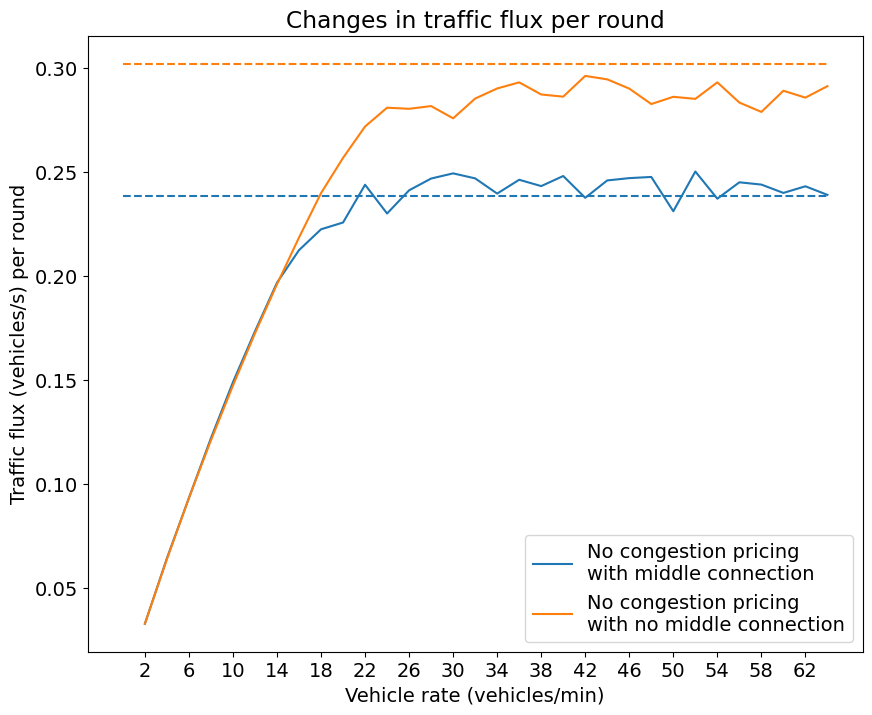

In [29]:
flux = [vehicle_limit/t for t in round_times]
opt_flux = [vehicle_limit/t for t in opt_round_times]

# Plot the data points except for when the vehicle rate is 1000
plt.plot(rate_range[:-1], flux[:-1], label='No congestion pricing\nwith middle connection')
plt.plot(rate_range[:-1], opt_flux[:-1], label='No congestion pricing\nwith no middle connection')

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.hlines(flux[-1], 0, 64, linestyles='--', color='tab:blue')
plt.hlines(opt_flux[-1], 0, 64, linestyles='--', color='tab:orange')

# Add other plot features
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel("Traffic flux (vehicles/s) per round")
plt.title("Changes in traffic flux per round")
plt.xticks(np.arange(min(rate_range[:-1]), max(rate_range[:-1])+1, 4))
plt.legend()

plt.savefig("Analysis/Change_in_flux_per_round_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - Traffic density vs. traffic flux

In [30]:
def compute_density(record_df, 
                    target_round, 
                    rate,
                    road_length = 300):
    """
    This function returns the maximum traffic density of the simulation throughout
    the duration of a round.
    
    Parameters:
        record_df: dataframe that stores data collected from the simulation
        target_round: the label of the round to be investigated
        rate: value of corresponding vehicle rate
        road_length: the total lengths covered by each vehicle; according to the setup
                     of this thesis, this value is 300=150 (length of 1 road segment)*2
    """
    # Extract only the records for the target round
    sub_record = record_df.loc[(record_df.Round_number==target_round)].reset_index(drop=True)
    
    # Summarize the average travel time for each combination of vehicle and route
    pivot_df = pd.pivot_table(sub_record, values='Total_time', 
                              index=['Vehicle_label', 'Road_order_label'], 
                              aggfunc=np.mean).reset_index(drop=False)
    
    road_density = {}
    
    # Iterate all routes
    for o in pivot_df.Road_order_label.unique():
        starts, ends = [], []
        # Only extract average travel time for each vehicle when they choose the current route
        df_tmp = pivot_df.loc[pivot_df.Road_order_label==o].reset_index(drop=True)

        for idx, row in df_tmp.iterrows():
            label = df_tmp.at[idx, "Vehicle_label"]
            time = df_tmp.at[idx, "Total_time"]
            
            # Computes the starting and ending time points
            # of the current vehicle's appearance in the network
            start_time = (label-1) * 60/rate
            end_time = start_time + time

            starts.append(start_time)
            ends.append(end_time)
            
        num_points = len(starts)
        max_cnt = 0
        
        # Count how many vehicles are appearing in the network at the same time for
        # each time point and find the maximum value among them
        for k in np.arange(min(starts), max(ends)+0.5, 0.5):
            cnt = 0
            for i in range(num_points):
                if starts[i] <= k and ends[i] >= k:
                    cnt += 1
            if cnt > max_cnt:
                max_cnt = cnt
        
        # Convert the count of vehicles into road density measure
        road_density[o] = [max_cnt / road_length]
                
    return road_density

In [31]:
all_road_density = []
target_number_of_rounds = 15

# Compute the maximum road density for the last 15 rounds for each vehicle rate
# and take the average value of them
for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)
    
    road_density = compute_density(record_df, rounds, i)
    for j in range(1, target_number_of_rounds):
        for k in road_density.keys():
            road_density[k].append(compute_density(record_df, rounds-j, i)[k][0])
            
    for k in road_density.keys():
        road_density[k] = sum(road_density[k]) / target_number_of_rounds
    
    all_road_density.append(road_density)

In [32]:
opt_all_road_density = []

# Compute the maximum road density for the last 15 rounds for each vehicle rate
# and take the average value of them
for idx in range(len(rate_range)):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, sub_routes)
    
    road_density = compute_density(record_df, rounds, i)
    for j in range(1, target_number_of_rounds):
        for k in road_density.keys():
            road_density[k].append(compute_density(record_df, rounds-j, i)[k][0])
            
    for k in road_density.keys():
        road_density[k] = sum(road_density[k]) / target_number_of_rounds
    
    opt_all_road_density.append(road_density)

In [33]:
opt_avg_density_l, avg_density_l = [], []

# Take the average road density of all the routes
for idx in range(len(rate_range)):
    opt_avg_density = (opt_all_road_density[idx][0] + opt_all_road_density[idx][1]) / 2
    avg_density = (all_road_density[idx][0] + all_road_density[idx][1] + \
                   all_road_density[idx][2] + all_road_density[idx][3]) / 4
    
    opt_avg_density_l.append(opt_avg_density)
    avg_density_l.append(avg_density)

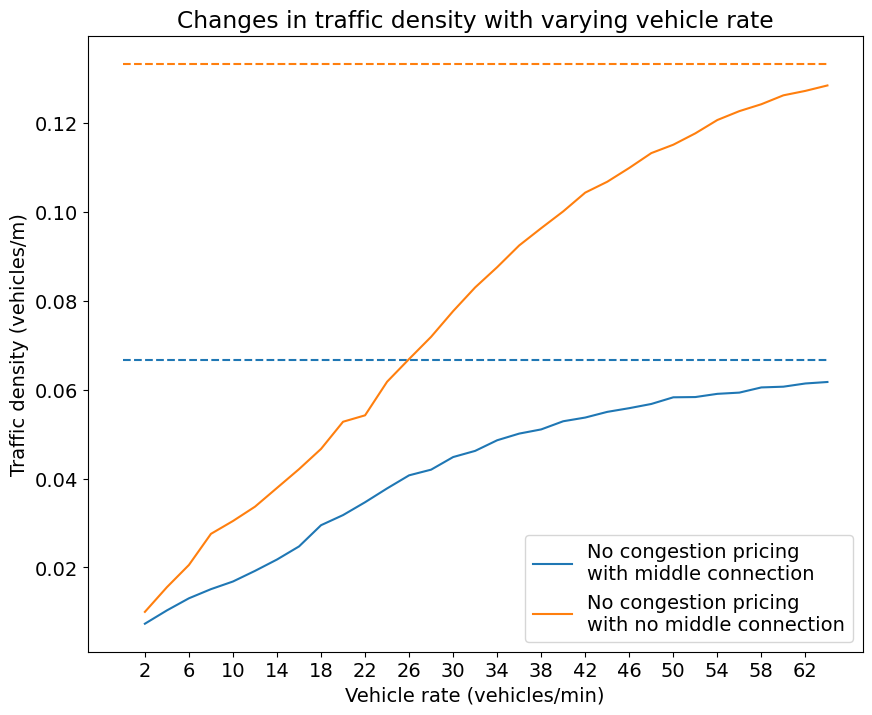

In [34]:
# Plot the data points except for when the vehicle rate is 1000
plt.plot(rate_range[:-1], avg_density_l[:-1], label="No congestion pricing\nwith middle connection")
plt.plot(rate_range[:-1], opt_avg_density_l[:-1], label='No congestion pricing\nwith no middle connection')

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.hlines(avg_density_l[-1], 0, 64, linestyles='--', color='tab:blue')
plt.hlines(opt_avg_density_l[-1], 0, 64, linestyles='--', color='tab:orange')

# Add other plot features
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel("Traffic density (vehicles/m)")
plt.title('Changes in traffic density with varying vehicle rate')
plt.xticks(np.arange(min(rate_range[:-1]), max(rate_range[:-1])+1, 4))
plt.legend(loc="lower right")

plt.savefig("Analysis/Changes_in_Density_with_rate_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

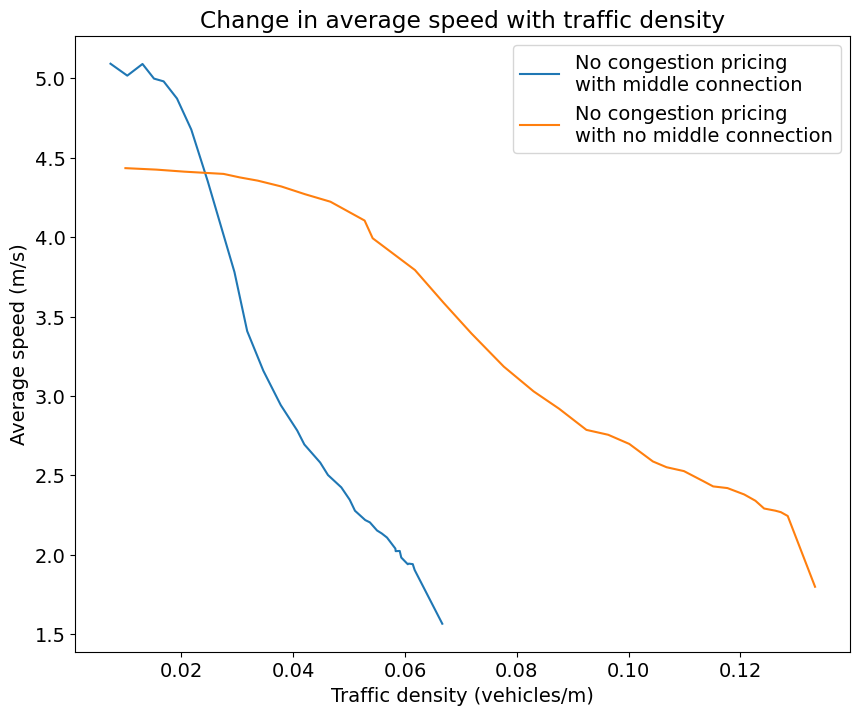

In [35]:
plt.rcParams["figure.figsize"] = (10,8)

# Compute average vehicle speed values
avg_speed = [300/t for t in avg_times]
opt_avg_speed = [300/t for t in opt_avg_times]

# Plot the average speed for all vehicle rates
plt.plot(avg_density_l, avg_speed, label="No congestion pricing\nwith middle connection")
plt.plot(opt_avg_density_l, opt_avg_speed, label='No congestion pricing\nwith no middle connection')

# Add other plot features
plt.xlabel("Traffic density (vehicles/m)")
plt.ylabel("Average speed (m/s)")
plt.title("Change in average speed with traffic density")
plt.legend()

plt.savefig("Analysis/Changes_in_Speed_with_Density_rescale.png",
            bbox_inches = 'tight', pad_inches=0.25)

plt.show()

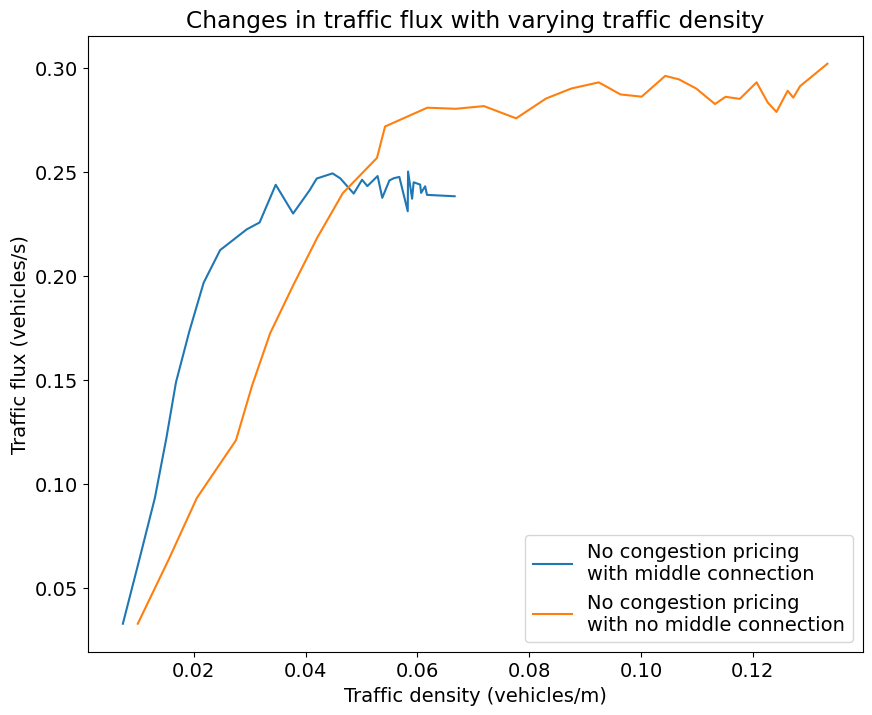

In [36]:
# Plot the average flux against average density for all vehicle rates
plt.plot(avg_density_l, flux, label="No congestion pricing\nwith middle connection")
plt.plot(opt_avg_density_l, opt_flux, label='No congestion pricing\nwith no middle connection')

# Add other plot features
plt.xlabel("Traffic density (vehicles/m)")
plt.ylabel("Traffic flux (vehicles/s)")
plt.title('Changes in traffic flux with varying traffic density')
plt.legend()

plt.savefig("Analysis/Changes_in_Density_with_Flux_rescale.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The total utility of all vehicles in the last few rounds

### Zero alpha case

In [37]:
# Compute the average utility value for each vehicle in each round for the last 15 rounds
target_number_of_rounds = 15
utilities_0 = []

for i in rate_range:
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.1 Zero alpha"
                                   )
    utilities_0.append(sum(total_utilities)/target_number_of_rounds/vehicle_limit)

### No connection case

In [38]:
utilities_no = []

for i in rate_range:
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.2 No connection"
                                   )
    utilities_no.append(sum(total_utilities)/target_number_of_rounds/vehicle_limit)

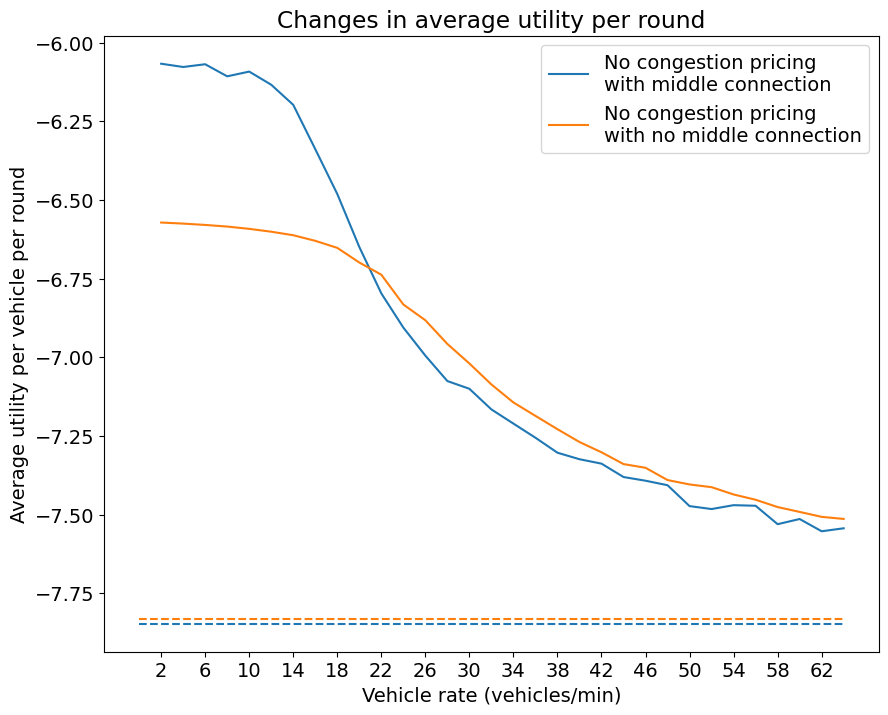

In [39]:
# Plot the data points except for when the vehicle rate is 1000
plt.plot(rate_range[:-1], utilities_0[:-1], label='No congestion pricing\nwith middle connection')
plt.plot(rate_range[:-1], utilities_no[:-1], label='No congestion pricing\nwith no middle connection')

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.hlines(utilities_0[-1], 0, 64, linestyles='--', color='tab:blue')
plt.hlines(utilities_no[-1], 0, 64, linestyles='--', color='tab:orange')

# Add other plot features
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel("Average utility per vehicle per round")
plt.title("Changes in average utility per round")
plt.xticks(np.arange(min(rate_range[:-1]), max(rate_range[:-1])+1, 4))
plt.legend()

plt.savefig("Analysis/Change_in_avg_utility_per_round_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

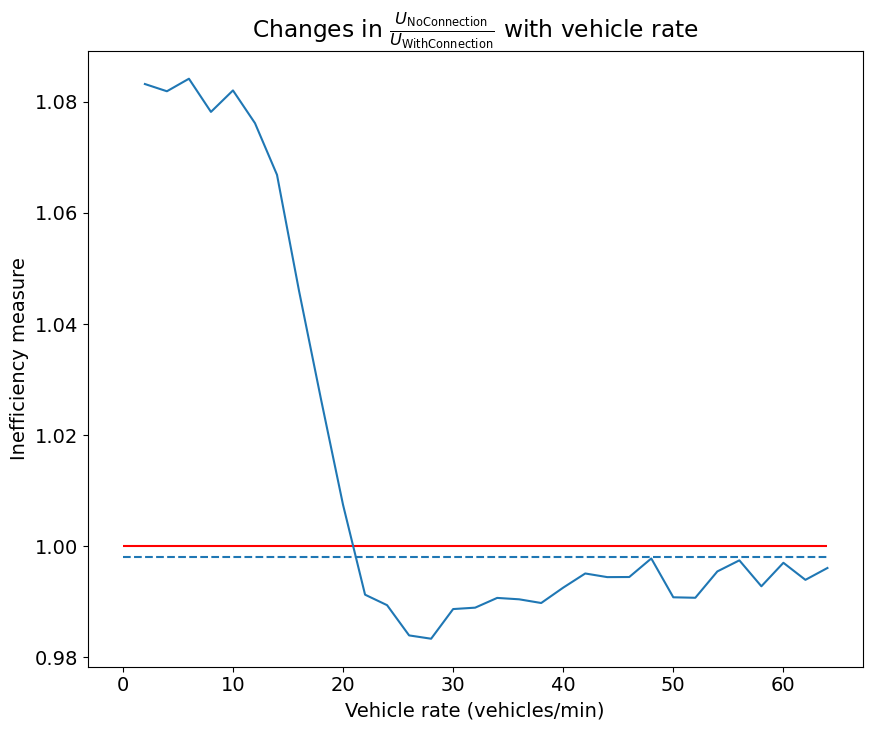

In [40]:
PoA2 = [1/(utilities_0[i] / utilities_no[i]) for i in range(len(utilities_0))]
# Plot the data points except for when the vehicle rate is 1000
plt.plot(rate_range[:-1], PoA2[:-1])

# Plot the values for when the vehicle rate is 1000 as dotted lines
plt.hlines(PoA2[-1], 0, 64, linestyles='--', color='tab:blue')

plt.hlines(1, 0, 64, color='r')
plt.xlabel("Vehicle rate (vehicles/min)")
plt.ylabel(r"Inefficiency measure")
plt.title(r"Changes in $\frac{U_{\mathrm{NoConnection}}}{U_{\mathrm{WithConnection}}}$ with vehicle rate")

plt.savefig("Analysis/Changes_in_utility_Inefficiency_with_rate_notext.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()